In [1]:
import numpy as np
import pandas as pd

# 1. Загружаем данные и анализируем датасет

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
# Подгружаем данные из соревнования
df_train = pd.read_csv('hotels_train.csv') 
df_test = pd.read_csv('hotels_test.csv') 
sample_submission = pd.read_csv('submission.csv') 

In [3]:
df_train['sample'] = 1           # помечаем где у нас трейн
df_test['sample'] = 0            # помечаем где у нас тест
df_test['reviewer_score'] = 0    # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train 
hotels.describe()

C:\Users\Колесник Дмитрий\AppData\Local\Temp\ipykernel_14320\1375254428.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [4]:
# проверяем датасет на наличие строковых данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 2. Очистка и обработка датасета

# 2.1 Работа с адресами отелей

Я хотела поработать с адресом отеля и выделить такие признаки как страна и город

In [5]:
# выделяем отдельный датасет для признаков, которые относятся к отелям и присваиваем индекс каждому отелю
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']
# удаляем дубликаты данных
only_hotels = hotels[hotel_cols].drop_duplicates().reset_index(drop=True)
only_hotels['hotel_id'] = only_hotels.index

In [6]:
only_hotels.head()

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,hotel_id
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,8.1,16670,904,0
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,8.6,5018,612,1
2,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520,8.3,351,46,2
3,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,9.1,1543,241,3
4,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,9.1,4687,834,4


In [7]:
# из основного датасета удалим признаки, которые относятся к отелю, и добавим id. Потом будем отдельно добавлять нужные признаки 
hotels = hotels.merge(only_hotels, on=hotel_cols, how='left')
hotels = hotels.drop(hotel_cols, axis=1)
hotels.head()

,review_date,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,hotel_id
0,7/21/2017,United Kingdom,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,0
1,12/12/2016,Belgium,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,1
2,11/26/2015,Sweden,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,2
3,10/17/2015,United States of America,No Negative,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,0.0,3
4,5/16/2016,United Kingdom,No Negative,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,0,0.0,4


In [8]:
# Выделяем страну, город и почтовый индекс из адреса отеля
only_hotels['city'] = only_hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
only_hotels['country'] = only_hotels.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
only_hotels['zip'] = only_hotels.hotel_address.apply(lambda x: x.split()[-4]+' '+x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])

In [9]:
only_hotels

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,hotel_id,city,country,zip
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,8.1,16670,904,0,Milan,Italy,20161
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,8.6,5018,612,1,Amsterdam,Netherlands,1043 EW
2,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520,8.3,351,46,2,Barcelona,Spain,08008
3,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,9.1,1543,241,3,Milan,Italy,20124
4,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,9.1,4687,834,4,Amsterdam,Netherlands,1012 WJ
...,...,...,...,...,...,...,...,...,...,...,...
1489,45 Park Lane Dorchester Collection,45 Park Lane Westminster Borough London W1K 1P...,51.506371,-0.151536,9.4,68,27,1489,London,United Kingdom,W1K 1PN
1490,Hotel Sezz Paris,6 Avenue Fr miet 16th arr 75016 Paris France,48.856634,2.285261,8.4,132,14,1490,Paris,France,75016
1491,L Edmond H tel,22 avenue de Villiers 17th arr 75017 Paris France,48.882311,2.313237,8.2,174,24,1491,Paris,France,75017
1492,Drawing Hotel,17 rue de Richelieu 1st arr 75001 Paris France,48.864438,2.335915,8.9,67,5,1492,Paris,France,75001


In [10]:
# уникальных значений городов и стран всего 6
display(only_hotels['city'].unique())
display(only_hotels['country'].unique())

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

In [11]:
# признаки с численностью населения страны и города отеля
сity_population = {
    'Milan': 1399860, 'Amsterdam': 872757,
    'Barcelona': 1664182, 'London': 8961989,
    'Paris': 2148327, 'Vienna': 1921153
}
only_hotels['сity_population'] = only_hotels['city'].map(сity_population)
country_population = {
    'Italy': 59257566, 'Netherlands': 17441500,
    'Spain': 47363419, 'United Kingdom': 67081000,
    'France': 64844037, 'Austria': 8916864
}
only_hotels['country_population'] = only_hotels['country'].map(country_population)
only_hotels['%_city_pop_from_country_pop'] = only_hotels['сity_population'] / only_hotels['country_population']

In [12]:
#Будем считать среднюю географическую координату для заполнения пропусков
geography = only_hotels.groupby(['city', 'zip']).agg({'lat' : 'mean', 'lng' : 'mean'})
only_hotels = only_hotels.merge(geography, on=['city', 'zip'], suffixes=('', '_avg'))

only_hotels[only_hotels.lat.isna()].head()

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,hotel_id,city,country,zip,сity_population,country_population,%_city_pop_from_country_pop,lat_avg,lng_avg
199,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,NaN,NaN,7.8,2724,214,35,Vienna,Austria,1090,1921153,8916864,0.215452,48.222805,16.358220
200,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,NaN,NaN,8.0,675,44,343,Vienna,Austria,1090,1921153,8916864,0.215452,48.222805,16.358220
205,Hotel Pension Baron am Schottentor,W hringer Stra e 12 09 Alsergrund 1090 Vienna ...,NaN,NaN,8.0,1315,122,1009,Vienna,Austria,1090,1921153,8916864,0.215452,48.222805,16.358220
267,Hotel Advance,Sep lveda 180 Eixample 08011 Barcelona Spain,NaN,NaN,8.3,156,18,1484,Barcelona,Spain,08011,1664182,47363419,0.035136,41.386019,2.159606
333,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France,NaN,NaN,8.8,1524,172,924,Paris,France,75008,2148327,64844037,0.033131,48.871954,2.310690


In [13]:
# Будем заменять пропуски в географических данных, исходя из индексов
only_hotels['lat'] = np.where(only_hotels.lat.isna(), only_hotels.lat_avg, only_hotels.lat)
only_hotels['lng'] = np.where(only_hotels.lng.isna(), only_hotels.lng_avg, only_hotels.lng)
only_hotels = only_hotels.drop(['lat_avg', 'lng_avg'], axis=1)

In [14]:
# Проверяем, остались ли пропуски
only_hotels.isnull().mean()

hotel_name                      0.0
hotel_address                   0.0
lat                             0.0
lng                             0.0
average_score                   0.0
total_number_of_reviews         0.0
additional_number_of_scoring    0.0
hotel_id                        0.0
city                            0.0
country                         0.0
zip                             0.0
сity_population                 0.0
country_population              0.0
%_city_pop_from_country_pop     0.0
dtype: float64

In [15]:
# соединяем назад наши датасеты
hotels = hotels.merge(only_hotels, on='hotel_id', how='left')

# кодируем город и индекс с помощью  метода LabelEncode
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
hotels['city'] = LabelEncoder().fit_transform(hotels['city'])
hotels['zip'] = LabelEncoder().fit_transform(hotels['zip'])

hotels.head()

,review_date,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,...,lng,average_score,total_number_of_reviews,additional_number_of_scoring,city,country,zip,сity_population,country_population,%_city_pop_from_country_pop
0,7/21/2017,United Kingdom,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,...,9.171102,8.1,16670,904,3,Italy,187,1399860,59257566,0.023623
1,12/12/2016,Belgium,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,...,4.834443,8.6,5018,612,0,Netherlands,87,872757,17441500,0.050039
2,11/26/2015,Sweden,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,...,2.161520,8.3,351,46,1,Spain,7,1664182,47363419,0.035136
3,10/17/2015,United States of America,No Negative,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,...,9.196298,9.1,1543,241,3,Italy,158,1399860,59257566,0.023623
4,5/16/2016,United Kingdom,No Negative,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,0,...,4.888644,9.1,4687,834,0,Netherlands,52,872757,17441500,0.050039


In [16]:
# Оставляем ТОП 15 наиболее активных национальностей
most_active_nationalities= hotels['reviewer_nationality'].value_counts().nlargest(15).index
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x:x if x in most_active_nationalities else 'Other')

hotels.head(5)

,review_date,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,...,lng,average_score,total_number_of_reviews,additional_number_of_scoring,city,country,zip,сity_population,country_population,%_city_pop_from_country_pop
0,7/21/2017,United Kingdom,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,...,9.171102,8.1,16670,904,3,Italy,187,1399860,59257566,0.023623
1,12/12/2016,Belgium,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,...,4.834443,8.6,5018,612,0,Netherlands,87,872757,17441500,0.050039
2,11/26/2015,Other,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,...,2.161520,8.3,351,46,1,Spain,7,1664182,47363419,0.035136
3,10/17/2015,United States of America,No Negative,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,...,9.196298,9.1,1543,241,3,Italy,158,1399860,59257566,0.023623
4,5/16/2016,United Kingdom,No Negative,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,0,...,4.888644,9.1,4687,834,0,Netherlands,52,872757,17441500,0.050039


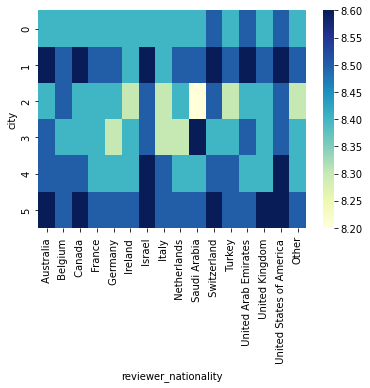

In [17]:
# Тепловая карта
import plotly.express as px
import seaborn as sns
table = pd.pivot_table(hotels,
               index='city',
               values='average_score',
               columns='reviewer_nationality',
               aggfunc = 'median') 

heatmap = sns.heatmap(data=table, cmap='YlGnBu')

In [18]:
hotels['reviewer_nationality'] = LabelEncoder().fit_transform(hotels['reviewer_nationality'])
hotels.head(5)

,review_date,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,...,lng,average_score,total_number_of_reviews,additional_number_of_scoring,city,country,zip,сity_population,country_population,%_city_pop_from_country_pop
0,7/21/2017,13,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,...,9.171102,8.1,16670,904,3,Italy,187,1399860,59257566,0.023623
1,12/12/2016,1,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,...,4.834443,8.6,5018,612,0,Netherlands,87,872757,17441500,0.050039
2,11/26/2015,15,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,...,2.161520,8.3,351,46,1,Spain,7,1664182,47363419,0.035136
3,10/17/2015,14,No Negative,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,...,9.196298,9.1,1543,241,3,Italy,158,1399860,59257566,0.023623
4,5/16/2016,13,No Negative,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,0,...,4.888644,9.1,4687,834,0,Netherlands,52,872757,17441500,0.050039


# 2.2 Работа с датами отзывов

In [19]:
# Работаем с датой отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# Разделяем один признак на несколько, чтобы проанализировать, зависит ли отзыв от месяца/времени года или дня недели
hotels['day'] = hotels['review_date'].dt.day.astype(int)
hotels['month'] = hotels['review_date'].dt.month.astype(int)
hotels['year'] = hotels['review_date'].dt.year.astype(int)

hotels['day_of_week'] = hotels['review_date'].dt.dayofweek.astype(int)
hotels['is_weekend'] = hotels['day'].apply(lambda x: 1 if x>5 else 0) 

hotels['is_spring'] = hotels['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
hotels['is_summer'] = hotels['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
hotels['is_autumn'] = hotels['month'].apply(lambda x: 1 if x in [9,10,11] else 0)
hotels['is_winter'] = hotels['month'].apply(lambda x: 1 if x in [12,1,2] else 0)

hotels.drop(['review_date'], inplace=True, axis=1)

def since_review_func(x):
    string = str(x)
    return string.split()[0]
hotels['days_since_review'] = hotels['days_since_review'].apply(since_review_func)

hotels.head(5)

,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,...,%_city_pop_from_country_pop,day,month,year,day_of_week,is_weekend,is_spring,is_summer,is_autumn,is_winter
0,13,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,0,0.0,...,0.023623,21,7,2017,4,1,0,1,0,0
1,1,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,0,0.0,...,0.050039,12,12,2016,0,1,0,0,0,1
2,15,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,0,0.0,...,0.035136,26,11,2015,3,1,0,0,1,0
3,14,No Negative,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,0,0.0,...,0.023623,17,10,2015,5,1,0,0,1,0
4,13,No Negative,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,0,0.0,...,0.050039,16,5,2016,0,1,1,0,0,0


In [20]:
calendar = pd.pivot_table(
    data=hotels,
    index='month',
    values='reviewer_score',
    columns='day',
    aggfunc='median')

fig = px.imshow(calendar)
fig.show()


На диаграмме видно, что зимой и весной оценки выше (1-3 месяцы), а вот осенью оценки ниже (10-11 месяцы)

# 2.3 Работа с отзывами

Из нечисловых данных остались только три признака, все они относятся непосредственно к обзору на отель.

In [21]:
hotels.head(5)

,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,...,%_city_pop_from_country_pop,day,month,year,day_of_week,is_weekend,is_spring,is_summer,is_autumn,is_winter
0,13,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,0,0.0,...,0.023623,21,7,2017,4,1,0,1,0,0
1,1,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,0,0.0,...,0.050039,12,12,2016,0,1,0,0,0,1
2,15,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,0,0.0,...,0.035136,26,11,2015,3,1,0,0,1,0
3,14,No Negative,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,0,0.0,...,0.023623,17,10,2015,5,1,0,0,1,0
4,13,No Negative,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,0,0.0,...,0.050039,16,5,2016,0,1,1,0,0,0


Можно отметить, что часто появляются такие отзывы, как "No Negative" и "No Positive". В данном контексте эти словосочетания можно итерпретировать в обратном смысле. 

In [22]:
hotels['no_neg'] = 0
hotels['no_pos'] = 0

no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']

hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

hotels['negative_review'].value_counts()[:10]


                158085
 Breakfast         407
 Small room        373
 Location          368
 Everything        326
 Price             260
 Small rooms       188
 Expensive         142
 Room size         140
 Staff             130
Name: negative_review, dtype: int64

In [23]:
no_pos_list = ['no positive', 'nothing']

hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1

hotels['positive_review'].value_counts()[:10]

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

In [24]:
hotels['neg_len'] = hotels['negative_review'].map(len)
hotels['pos_len'] = hotels['positive_review'].map(len)

Анализ тональности текста

In [25]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

analyz = SentimentIntensityAnalyzer()

# проводим анализ текста с помощью SentimentIntensityAnalyzer()
hotels['review_neg'] = hotels['negative_review'].apply(lambda x: analyz.polarity_scores(x))
hotels['review_pos'] = hotels['positive_review'].apply(lambda x: analyz.polarity_scores(x))

# результаты помещаем в hotels
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['review_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['review_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

hotels.head(5)

[nltk_data] Downloading package vader_lexicon to C:\Users\Колесник
[nltk_data]     Дмитрий\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,...,review_neg,review_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,13,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,0,0.0,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,1,No tissue paper box was present at the room,10,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,0,0.0,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400
2,15,Pillows,3,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,0,0.0,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.000,0.260,0.740,0.6908
3,14,,0,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,0,0.0,...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...",0.000,0.000,0.000,0.0000,0.000,0.621,0.379,0.9153
4,13,,0,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,0,0.0,...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...",0.000,0.000,0.000,0.0000,0.000,0.230,0.770,0.7717


In [26]:
hotels['%_positive_words_in_review'] = hotels['review_total_positive_word_counts'] / \
     (hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts']) 
hotels['%_negative_words_in_review'] = hotels['review_total_negative_word_counts'] / \
     (hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts'])

hotels['#_positive_words_per_review'] = hotels['review_total_positive_word_counts'] / \
     hotels['total_number_of_reviews_reviewer_has_given']
hotels['#_negative_words_per_review'] = hotels['review_total_negative_word_counts'] / \
     hotels['total_number_of_reviews_reviewer_has_given']

In [27]:
# удаляем лишние данные

object_columns = [strings for strings in hotels.columns if hotels[strings].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)
hotels.drop(['zip'], axis = 1, inplace=True)
hotels.drop(['hotel_id'], axis = 1, inplace=True)

hotels = hotels.fillna(0)
print(hotels.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  int32  
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   sample                                      515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   average_score                               515738 non-null  float64
 9   total_number_of_reviews                     515738 non-null  int64  
 

<AxesSubplot:>

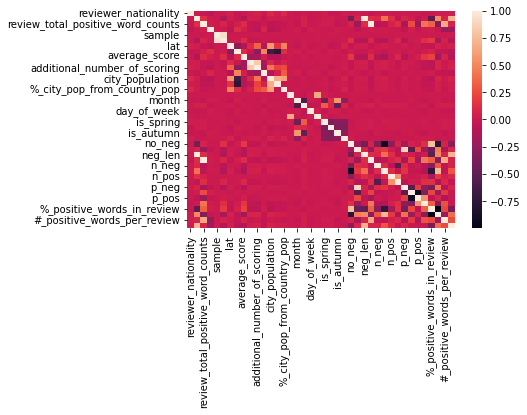

In [28]:
# проверим, нужно ли еще что-то удалять
sns.heatmap(hotels.corr())

# 3. Нормализуем данные

In [29]:
# числовые признаки
num_cols = ['review_total_negative_word_counts', 
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'total_number_of_reviews', 'reviewer_score',
            'additional_number_of_scoring',
            'сity_population', 'country_population',
            '%_city_pop_from_country_pop',
            'neg_len', 'pos_len',
            'n_neu', 'n_pos','n_neg',
            'n_compound','p_compound',
            'p_neg', 'p_neu', 'p_pos',
            '%_positive_words_in_review', '%_negative_words_in_review',
            '#_positive_words_per_review', '#_negative_words_per_review'
            ]

# категориальные признаки
cat_cols = ['reviewer_nationality',
            'lat', 'lng',
            'city','day',
            'month', 'year', 
            'day_of_week', 'is_weekend',
            'is_spring', 'is_summer',
            'is_autumn', 'is_winter',
            'no_neg', 'no_pos',    
            'average_score',           
            ]         

month                       0.055775
day_of_week                 2.304557
is_spring                  19.852313
city                       38.280350
is_weekend                 46.876865
lng                        58.976861
year                       64.948509
reviewer_nationality      127.130887
lat                       145.960172
is_autumn                 288.985899
is_summer                 378.424153
day                       730.514737
no_pos                   1878.030240
average_score            4928.562297
no_neg                  31369.811894
is_winter               55549.543173
dtype: float64

<AxesSubplot:>

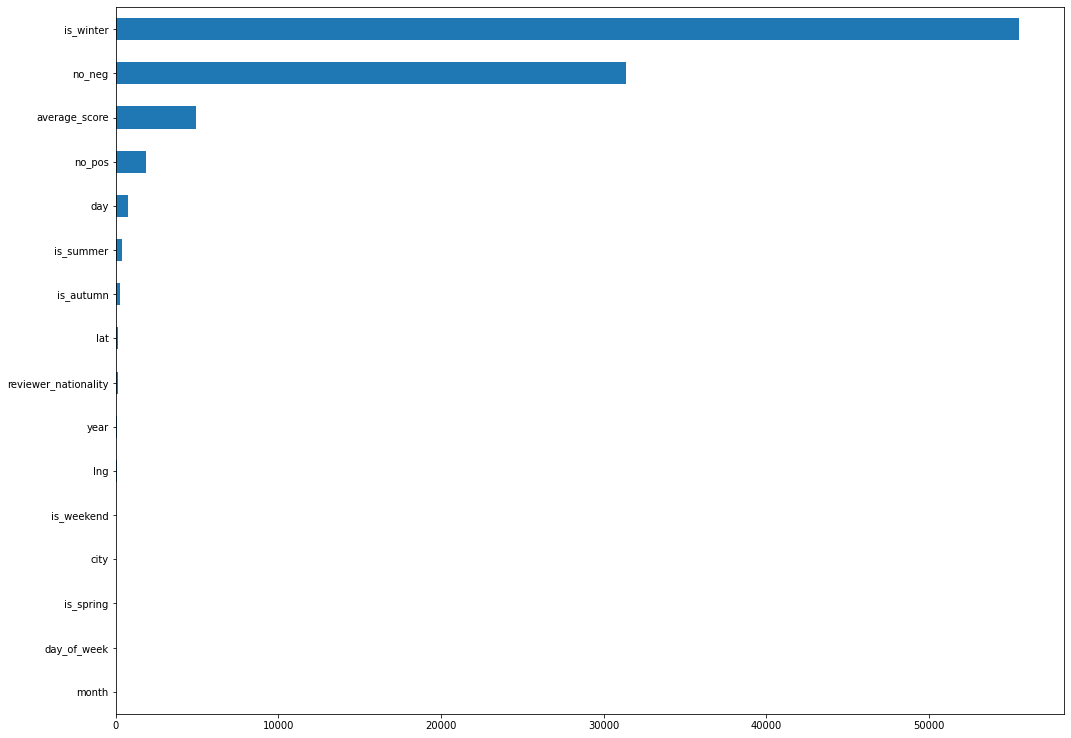

In [30]:
from sklearn.feature_selection import chi2 # хи-квадрат
import matplotlib.pyplot as plt
%matplotlib inline

# Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат.
# Выведем значения хи-квадрат на графике:

y = hotels.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = hotels.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X = X.drop(['lng'], axis=1)

plt.rcParams['figure.figsize'] = (17,13)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
display(imp_cat)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

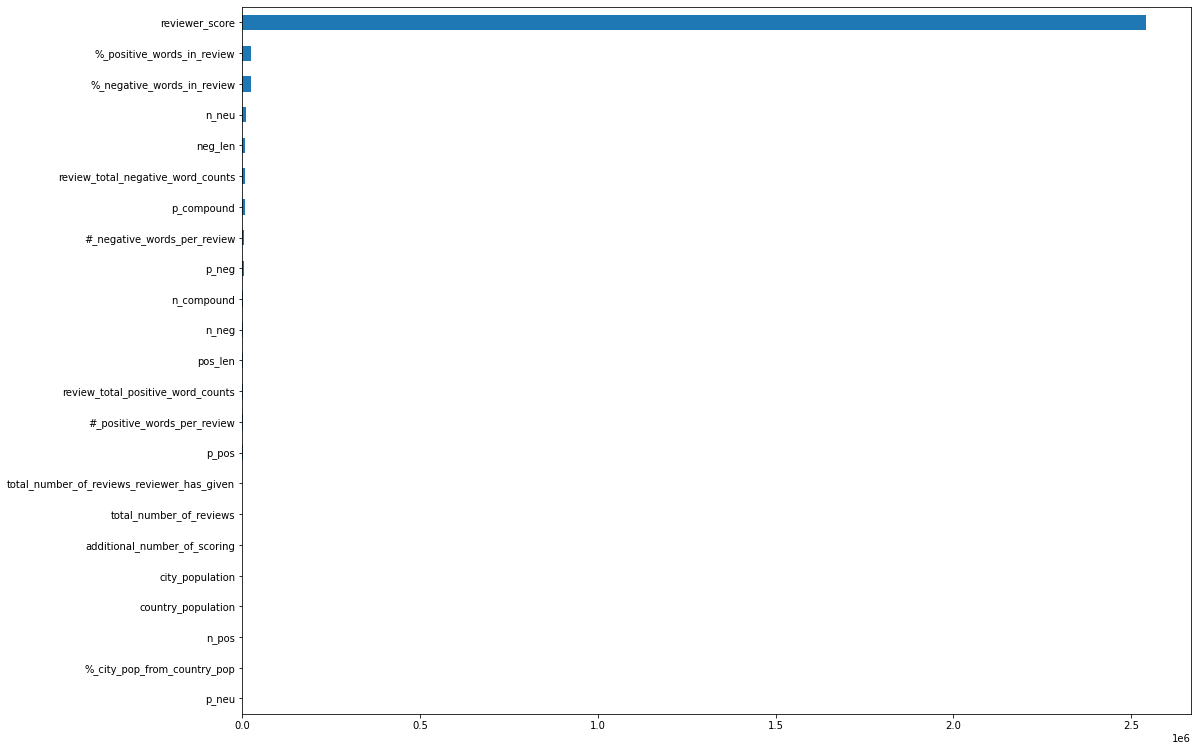

In [31]:
from sklearn.feature_selection import f_classif # anova
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = hotels.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = hotels.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
plt.rcParams['figure.figsize'] = (17,13)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [32]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
pivot = hotels.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.layout.height = 800
fig.layout.width = 800
fig.show()

# постараемся удалить как можно меньше признаков. Сначала удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = hotels.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

Deleted 39 columns


# 4. Обучение модели

In [33]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)
train_data

,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,...,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,%_positive_words_in_review,%_negative_words_in_review,#_positive_words_per_review
128935,13,3,4,7,10.0,51.507894,-0.143671,8.4,1994,581,...,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859,0.571429,0.428571,0.571429
128936,13,3,2,14,6.3,51.521009,-0.123097,8.3,1361,299,...,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000,0.400000,0.600000,0.142857
128937,15,6,0,14,7.5,48.845377,2.325643,8.9,406,32,...,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400,0.000000,1.000000,0.000000
128938,13,0,11,8,10.0,48.888697,2.394540,7.5,607,34,...,0.000,0.0,0.0000,0.000,0.279,0.721,0.9169,1.000000,0.000000,1.375000
128939,15,4,20,10,9.6,52.385601,4.847060,8.5,7586,914,...,0.333,0.0,-0.2500,0.000,0.618,0.382,0.8503,0.833333,0.166667,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,3,0,10,10,8.8,51.494028,-0.191050,9.0,617,107,...,0.000,0.0,0.0000,0.000,1.000,0.000,0.0000,1.000000,0.000000,1.000000
515734,11,0,93,1,9.2,48.192379,16.399451,8.4,3224,272,...,0.000,0.0,0.0000,0.045,0.857,0.098,0.7264,1.000000,0.000000,93.000000
515735,8,12,9,21,8.3,51.520795,-0.131084,6.8,2751,457,...,1.000,0.0,0.0000,0.000,0.465,0.535,0.7845,0.428571,0.571429,0.428571
515736,12,0,6,28,9.2,51.515125,-0.160066,8.1,1567,365,...,0.000,0.0,0.0000,0.000,1.000,0.000,0.0000,1.000000,0.000000,0.214286


In [34]:
# Разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [35]:
# проверяем размерности получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [36]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [37]:
# Обучаем модель
model.fit(X_train, y_train)

# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


In [38]:
# Пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.861977075658277
MAPE: 12.235265289547751


<AxesSubplot:>

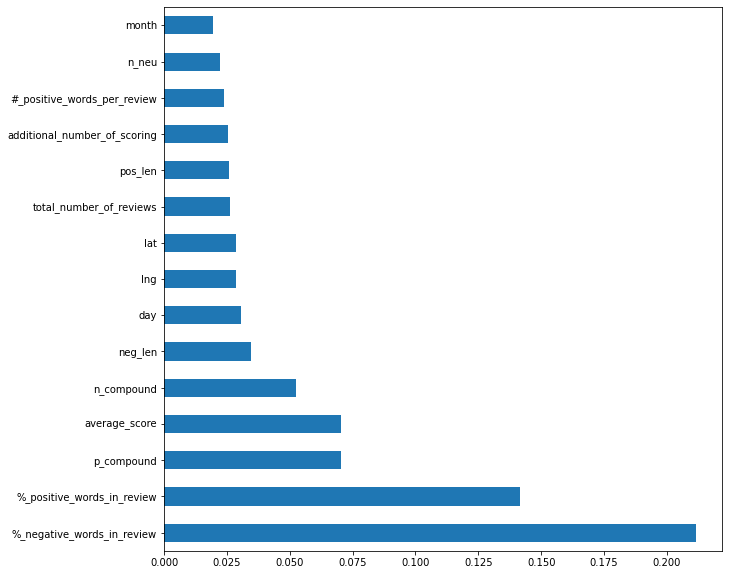

In [40]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [41]:
test_data = test_data.drop(['reviewer_score'], axis=1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        128935 non-null  int32  
 1   review_total_negative_word_counts           128935 non-null  int64  
 2   review_total_positive_word_counts           128935 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 4   lat                                         128935 non-null  float64
 5   lng                                         128935 non-null  float64
 6   average_score                               128935 non-null  float64
 7   total_number_of_reviews                     128935 non-null  int64  
 8   additional_number_of_scoring                128935 non-null  int64  
 9   city                                        128935 non-null  int32  
 

In [42]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


In [43]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.670,488440
1,7.316,274649
2,8.260,374688
3,9.766,404352
4,9.632,451596
5,9.442,302161
6,7.482,317079
7,7.539,13963
8,8.428,159785
9,7.398,195089
